### Deep Learning - Project 21
#### Week 1:
This week we want to implement the first steps of the project. We want to understand and visualize the data and get acquainted with the TIF file. We want to try to use the U-net model on the small dataset that the professor gave (all images have a corresponding mask - fully supervised).

In [ ]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import TensorDataset, random_split, DataLoader
from scipy.ndimage import gaussian_filter
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split

##### Step 1 - Visualize the tomography images :
The images are TIF files with 32 bit depth and dimension 768x768. The TIF file does not compress the data, so it is lossless. The TIF file can be a 3D stack (a volume) but that is not the case. The following code allows to view the image from the TIF file and now some of its characteristics.

In [ ]:
# Choose what file to upload
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: 

In [ ]:
# Get filename
filename = list(uploaded.keys())[0]

# Load image
img = tiff.imread(filename)

# Print intensity stats
print("Image dtype:", img.dtype)
print("Min intensity:", np.min(img))
print("Max intensity:", np.max(img))
print("Mean intensity:", np.mean(img))

# Stretch contrast manually
img_stretched = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
img_stretched = img_stretched.astype(np.uint8)

# Show image
plt.figure(figsize=(8, 8))
plt.imshow(img_stretched, cmap='gray')
plt.title("Contrast-Stretched Micro-CT Image")
plt.axis('off')
plt.show()

#### Step 2 - Visualize the SIMUPOR images:
First we have to look at the SIMUPOR images that we are using to pre-train the u-net model (baseline model). First, we have to preprocess the samples (normalize and denoise).

###2.1 Load the SIMUPOR data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/SIMUPOR/test /content/SIMUPOR


Mounted at /content/drive


In [ ]:
from PIL import Image, UnidentifiedImageError

images_path = "/content/SIMUPOR/images"
masks_path  = "/content/SIMUPOR/masks"

image_files = sorted(os.listdir(images_path))
mask_files  = sorted(os.listdir(masks_path))

# List to hold all image tensors
image_list = []
mask_list = []

for img_file, mask_file in zip(image_files, mask_files):
    img_path = os.path.join(images_path, img_file)
    mask_path = os.path.join(masks_path, mask_file)

    if not (img_file.lower().endswith(".png") and mask_file.lower().endswith(".npy")):
        continue

    # Verify if the file is valid
    try:
        with Image.open(img_path) as tmp:
            tmp.verify()
    except (UnidentifiedImageError, OSError):
        continue

    image_list.append(img_path)
    mask_list.append(mask_path)


print("Loaded:")
print("Images:", len(image_list))
print("Masks:", len(mask_list))

Loaded:
Images: 6912
Masks: 6912


####2.2 Normalize and denoise the images (pre-processing tasks); Convert images to tensor; Convert mask to binary (0 -> background; otherwise -> pore)
We need to create a class called SimuporDataset because the RAM limitations wont allow to normalize and denoise the data all at once. The best aproach is to fit training, validation and testing datasets into a SimuporDataset each. Then the methods inside will allow it to be normalized and denoised automatically (trough getitem) (based on https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html).

In [ ]:
class SimuporDataset(Dataset):
    def __init__(self, image_paths, mask_paths, sigma=1.0):
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.sigma = sigma

    def normalize_and_denoise(self, img_np):
        img_norm = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)
        img_denoised = gaussian_filter(img_norm, sigma=self.sigma)
        return img_denoised

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image (L = grayscale)
        img = Image.open(self.image_paths[idx]).convert("L")
        img_np = np.array(img, dtype=np.float32)

        # Normalize + denoise
        img_np = self.normalize_and_denoise(img_np)

        img_tensor = torch.tensor(img_np).unsqueeze(0)  # [1,H,W]

        # Load mask
        mask_np = np.load(self.mask_paths[idx]).astype(np.float32)

        # convert to binary
        mask_np = (mask_np > 0).astype(np.float32)   # everything >0 becomes 1 (pore)

        # convert to tensor
        mask_tensor = torch.tensor(mask_np).unsqueeze(0)


        return img_tensor, mask_tensor


#### 2.3 Split into train, test and validation

In [ ]:
# 65% train, 35% temp
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(
    image_list, mask_list, test_size=0.35, random_state=42
)

# 35% split into 15% val, 20% test
val_imgs, test_imgs, val_masks, test_masks = train_test_split(
    temp_imgs, temp_masks, test_size=0.5714, random_state=42
)

print("Train:", len(train_imgs))
print("Val:  ", len(val_imgs))
print("Test: ", len(test_imgs))


Train: 4492
Val:   1037
Test:  1383


In [ ]:
# Pre-process the data
train_dataset = SimuporDataset(train_imgs, train_masks, sigma=1.0)
val_dataset   = SimuporDataset(val_imgs, val_masks, sigma=1.0)
test_dataset  = SimuporDataset(test_imgs, test_masks, sigma=1.0)


In [ ]:
# Load the data in batches
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=16, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=16, num_workers=2)


In [ ]:
imgs, masks = next(iter(train_loader))
print("Batch image tensor:", imgs.shape)
print("Batch mask tensor :", masks.shape)


Batch image tensor: torch.Size([16, 1, 256, 256])
Batch mask tensor : torch.Size([16, 1, 256, 256])


#### 2.4. Show the images and intensity distributions before and after processing

In [ ]:
def load_raw_image(path):
    img = Image.open(path).convert("L")
    return np.array(img, dtype=np.float32)

# choose the indices to display
indices = [0, 1320]

for idx in indices:

    raw_np = load_raw_image(image_list[idx])

    # build a temporary dataset with one element
    temp_dataset = SimuporDataset(
        [image_list[idx]],
        [mask_list[idx]],
        sigma=1.0
    )
    processed_np = temp_dataset[0][0].squeeze().numpy()

    # Display the differences
    plt.figure(figsize=(10,4))
    plt.suptitle(f"Image {idx}")

    plt.subplot(1,2,1)
    plt.imshow(raw_np, cmap="gray")
    plt.title("Raw")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(processed_np, cmap="gray")
    plt.title("Processed")
    plt.axis("off")

    plt.show()

## Step 3:
Now we can start creating the U-net model (taken from https://debuggercafe.com/unet-from-scratch-using-pytorch/).

#### 3.1 Define the U-Net model

In [ ]:

def double_convolution(in_channels, out_channels):
    """
    In the original paper implementation, the convolution operations were
    not padded but we are padding them here. This is because, we need the
    output result size to be same as input size.
    """
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )
    return conv_op

In [ ]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Contracting path.
        # Each convolution is applied twice.
        self.down_convolution_1 = double_convolution(1, 64)
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        self.down_convolution_5 = double_convolution(512, 1024)
        # Expanding path.
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=2,
            stride=2)
        # Below, `in_channels` again becomes 1024 as we are concatinating.
        self.up_convolution_1 = double_convolution(1024, 512)
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2,
            stride=2)
        self.up_convolution_2 = double_convolution(512, 256)
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2,
            stride=2)
        self.up_convolution_3 = double_convolution(256, 128)
        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2,
            stride=2)
        self.up_convolution_4 = double_convolution(128, 64)
        # output => `out_channels` as per the number of classes.
        self.out = nn.Conv2d(
            in_channels=64, out_channels=num_classes,
            kernel_size=1
        )
    def forward(self, x):
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8)
        # *** DO NOT APPLY MAX POOL TO down_9 ***

        up_1 = self.up_transpose_1(down_9)
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1))
        up_2 = self.up_transpose_2(x)
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1))
        up_3 = self.up_transpose_3(x)
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1))
        up_4 = self.up_transpose_4(x)
        x = self.up_convolution_4(torch.cat([down_1, up_4], 1))
        out = self.out(x)
        return out

#### 3.2 Define the loss functions

In [ ]:
def dice_loss(pred, target, smooth = 1.0):  #metric that prioritizes overlap between predictions and targets
    """
    The smooth argument is the smoothing factor to avoid division by zero.
    """
    # Apply sigmoid to convert logits to probabilities
    pred = torch.sigmoid(pred)

    # Calculate intersection and union
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))

    # Compute Dice Coefficient
    dice = (2. * intersection + smooth) / (union + smooth)

    # Return Dice Loss
    return 1 - dice.mean()

bce = nn.BCEWithLogitsLoss() # combines a Sigmoid layer and the Binary Cross Entropy between the target and the input probabilities

# we combine the dice loss and the bce loss
def combined_loss(pred, target, alpha=0.5):
    """
    alpha: weight for Dice vs CE
    """
    return alpha * dice_loss(pred, target) + (1 - alpha) * bce(pred, target)



#### 3.3 Define main model characteristics

In [ ]:

model = UNet(num_classes = 1) #Each pixel’s value represents the probability of being the foreground (pore)
loss_fn = combined_loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
print(model)

UNet(
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_convolution_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_convolution_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_convolution_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_convolution_4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(51

#### 3.4 Define the metrics to be analyzed

Dice:
Gives more weight to the intersection;
Penalizes false negatives less;
More forgiving when the object is small.

IoU:
Harder metric;
Penalizes mismatches more strongly;
Good for evaluating strict segmentation quality.

In [ ]:
def dice_score(pred, target, eps=1e-6):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return (2 * intersection + eps) / (union + eps)

In [ ]:
def iou_score(pred, target, eps=1e-6):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + eps) / (union + eps)

# Step 4:

Test the forward pass with dummy data

In [ ]:

# Create dummy input
batch_size = 4
channels = 1       # grayscale input
height = 256
width = 256

dummy_input = torch.randn(batch_size, channels, height, width).to(device)

# Initialize model
model = UNet(num_classes=1).to(device)   # binary segmentation
model.eval()

# Forward pass
with torch.no_grad():
    output = model(dummy_input)

# Check output shape
print("Input shape: ", dummy_input.shape)
print("Output shape:", output.shape)

# Apply sigmoid to get probabilities
probs = torch.sigmoid(output)
print("Probabilities range: min =", probs.min().item(), "max =", probs.max().item())
num_epochs = 10

Input shape:  torch.Size([4, 1, 256, 256])
Output shape: torch.Size([4, 1, 256, 256])
Probabilities range: min = 0.4728924036026001 max = 0.4878358244895935


# Step 5 - Supervised training with SIMUPOR dataset



#### 5.1. Train the model and evaluate with **dice score**

In [ ]:
model = model.to(device)

num_epochs = 10
validation_every_steps = 5

step = 0
model.train()

train_dices = []
valid_dices = []

for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()

        # compute dice score
        preds = (torch.sigmoid(output) > 0.5).float()
        dice = dice_score(preds, targets).item()
        train_dices.append(dice)

        step += 1

        # Validation
        if step % validation_every_steps == 0:
            model.eval()
            valid_d = []
            with torch.no_grad():
                for val_inputs, val_targets in val_loader:
                    val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                    val_output = model(val_inputs)

                    val_preds = (torch.sigmoid(val_output) > 0.5).float()
                    val_dice = dice_score(val_preds, val_targets).item()
                    valid_d.append(val_dice)

            valid_dices.append(np.mean(valid_d))
            model.train()

            print(f"Step {step:<5}   train_dice: {dice:.4f}   val_dice: {valid_dices[-1]:.4f}")

print("Finished training.")

KeyboardInterrupt: 

In [ ]:
# Sample train dices at the steps where validation was performed
train_sampled = train_dices[validation_every_steps-1::validation_every_steps]

# Steps for x-axis
steps = np.arange(1, len(valid_dices)+1) * validation_every_steps

# plot train and validation dice scores during training
plt.figure(figsize=(8,5))
plt.plot(steps, train_sampled, label='train')
plt.plot(steps, valid_dices, label='validation')
plt.xlabel('Training steps')
plt.ylabel('Dice score')
plt.title("Train and validation Dice score")
plt.legend()
plt.show()




NameError: name 'train_accuracies' is not defined

In [ ]:
# ONLY RUN WHEN SAVING THE DATA


# Path in your Drive
#save_path = "/content/drive/MyDrive/SIMUPOR/unet_simupor_weights.pth"

# Save only the model weights
#torch.save(model.state_dict(), save_path)

# Save checkpoint with optimizer state
#checkpoint_path = "/content/drive/MyDrive/SIMUPOR/unet_simupor_checkpoint.pth"
#torch.save({
#    'model_state_dict': model.state_dict(),
#    'optimizer_state_dict': optimizer.state_dict(),
#    'epoch': num_epochs
#}, checkpoint_path)

# Step 6 - Evaluate the model using dice score and iou score:

Upload the files with the weights and evaluate the test set

In [ ]:
# Uploading the weights from Drive
weights_path = "/content/drive/MyDrive/SIMUPOR/unet_simupor_weights.pth"

device = "cuda" if torch.cuda.is_available() else "cpu"

# Creates a new model and uploads the weights to it
model = UNet(num_classes=1).to(device)

state_dict = torch.load(weights_path, map_location=device)
model.load_state_dict(state_dict)

print("Weights loaded successfully")

Weights loaded successfully


#### 6.1. Evaluate using dice score

In [ ]:
# Testing result
model.eval()
test_dice_values = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        preds = (torch.sigmoid(output) > 0.5).float()
        dice = dice_score(preds, targets)
        test_dice_values.append(dice)

mean_test_dice = np.mean(test_dice_values)
var_test_dice  = np.var(test_dice_values)

print(f"Test dice score (mean): {mean_test_dice:.3f}       Test dice score (var): {var_test_dice:.3f}")

####6.2. Evaluate using iou score

In [ ]:
with torch.no_grad():
    model.eval()
    test_iou = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        output = model(inputs)
        loss = loss_fn(output, targets)

        preds = (torch.sigmoid(output) > 0.5).float()
        iou = iou_score(preds, targets).item()
        test_iou.append(iou)

    test_iou = np.mean(test_iou)
    var_test = np.var(test_iou)

    print(f"Test iou score (mean): {test_iou:.3f}       Test iou score (var): {var_test:.3f}")

    model.train()


Test iou score (mean): 0.874       Test iou score (var): 0.000


Visualize some image outputs

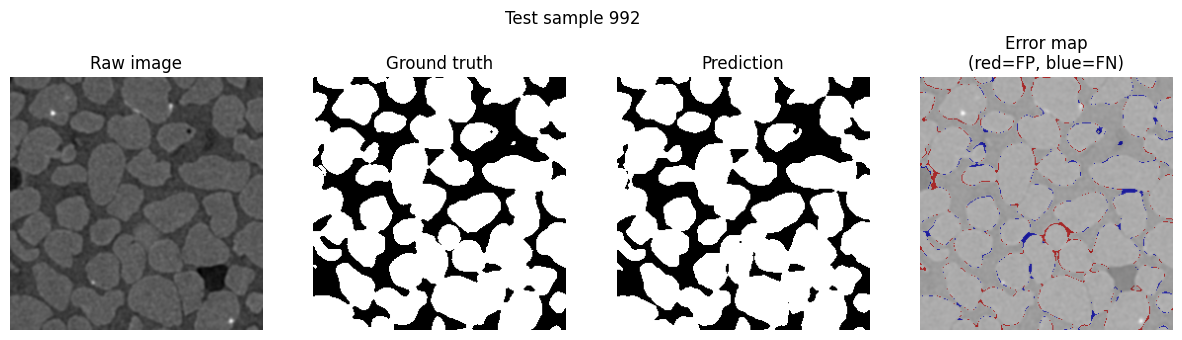

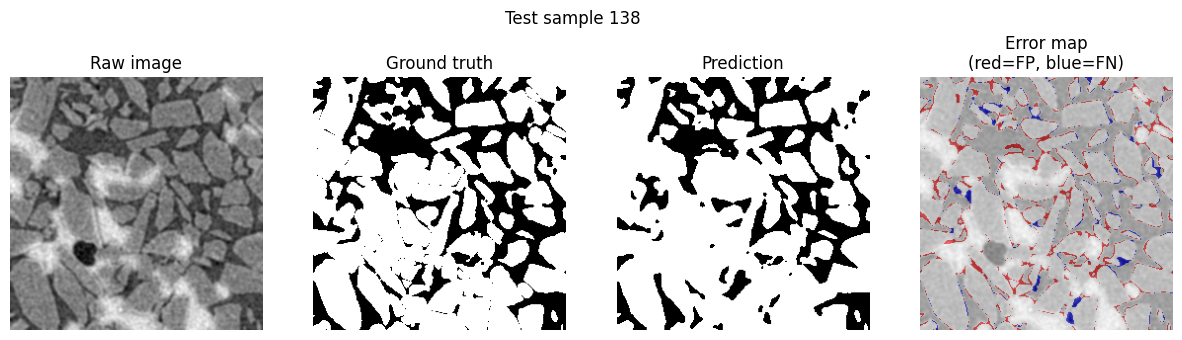

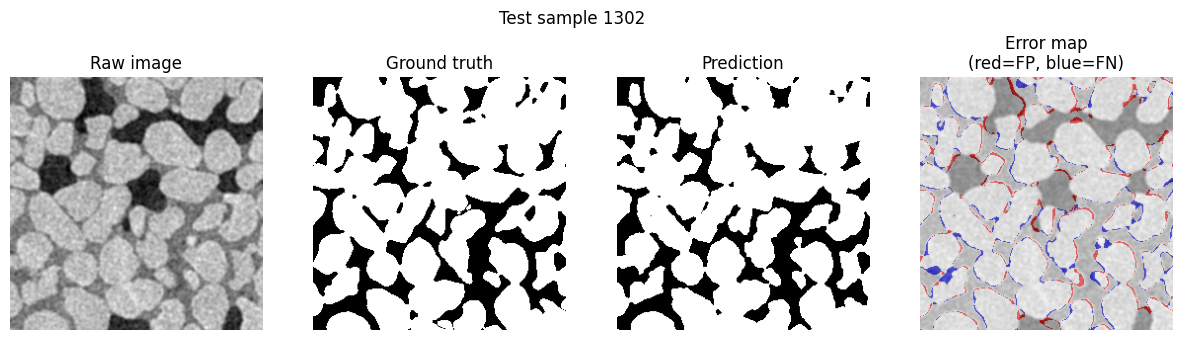

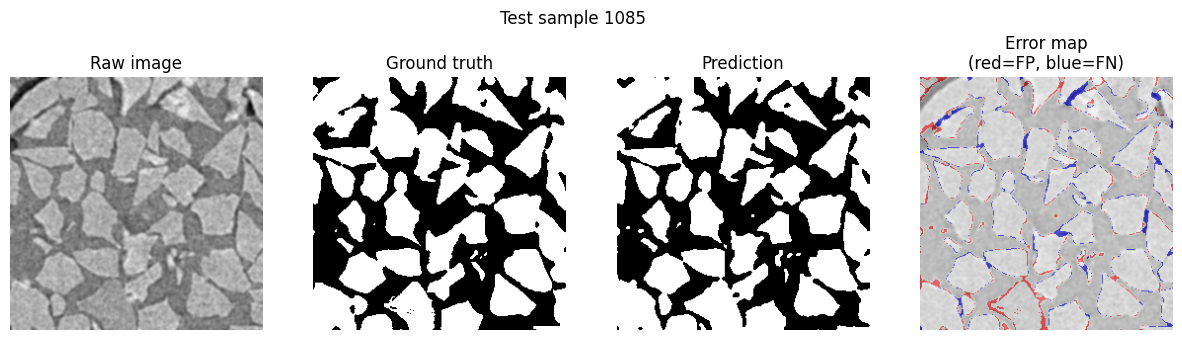

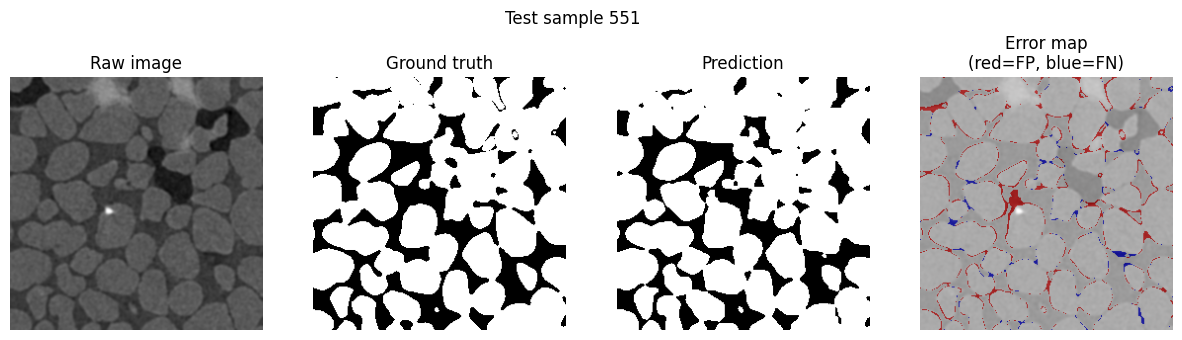

In [ ]:
model.eval()

# Choose some test samples
num_samples = 5
indices = np.random.choice(len(test_dataset), num_samples, replace=False)

for idx in indices:
    img_tensor, gt_mask = test_dataset[idx]
    img = img_tensor.unsqueeze(0).to(device)   # add batch dimension

    # Model prediction
    with torch.no_grad():
        output = model(img)
        preds = (torch.sigmoid(output) > 0.5).float()
        pred = preds.squeeze().cpu()
        pred_np = pred.numpy()

    # pred_np = (pred.squeeze().cpu().numpy() > 0.5).astype(np.float32)

    img_np = img_tensor.squeeze().numpy()
    gt_np  = gt_mask.squeeze().numpy()

    # -----------------------------
    # Visualization
    # -----------------------------
    plt.figure(figsize=(15,4))
    plt.suptitle(f"Test sample {idx}")

    plt.subplot(1,4,1)
    plt.imshow(img_np, cmap="gray")
    plt.title("Raw image")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(gt_np, cmap="gray")
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(pred_np, cmap="gray")
    plt.title("Prediction")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(img_np, cmap="gray")
    plt.imshow((pred_np - gt_np), cmap="bwr", alpha=0.5)
    plt.title("Error map\n(red=FP, blue=FN)")
    plt.axis("off")

    plt.show()


We have noticed that some masks might be wrongly labeled, which is the case of test sample 906. This issues might have affected our model's performance

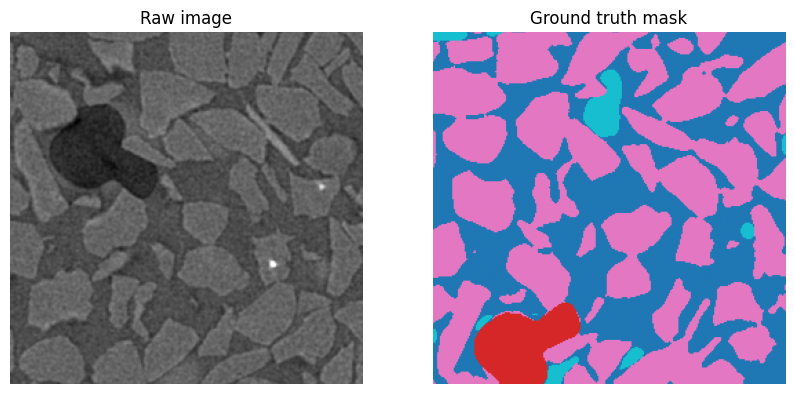

In [ ]:
idx = 906
mask_path = test_masks[idx]
mask_np = np.load(mask_path)
img_np = np.array(Image.open(test_imgs[idx]).convert("L"), dtype=np.float32)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_np, cmap="gray")
plt.title("Raw image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask_np, cmap="tab10")
plt.title("Ground truth mask")
plt.axis("off")
plt.show()


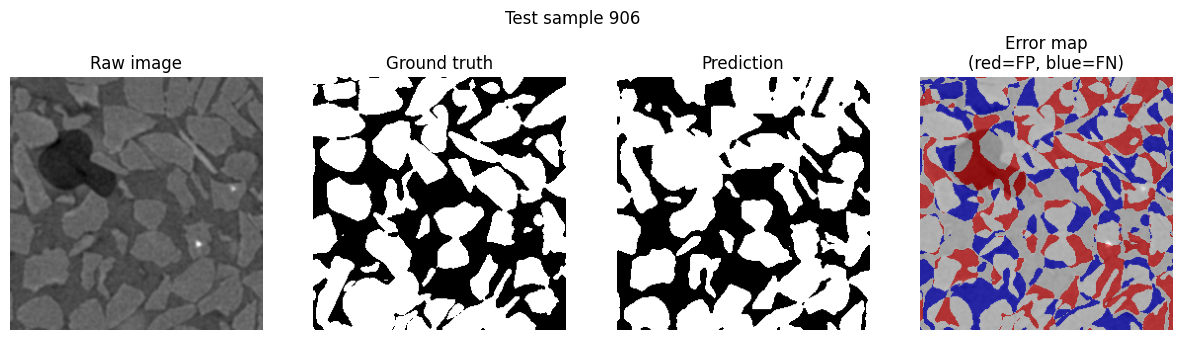

(256, 256) (256, 256)


In [ ]:
model.eval()

# Choose specific test sample
idx = 906
img_tensor, gt_mask = test_dataset[idx]
img = img_tensor.unsqueeze(0).to(device)   # add batch dimension

# Model prediction
with torch.no_grad():
    output = model(img)
    preds = (torch.sigmoid(output) > 0.5).float()
    pred = preds.squeeze().cpu()
    pred_np = pred.numpy()

img_np = img_tensor.squeeze().numpy()
gt_np  = gt_mask.squeeze().numpy()

# -----------------------------
# Visualization
# -----------------------------
plt.figure(figsize=(15,4))
plt.suptitle(f"Test sample {idx}")

plt.subplot(1,4,1)
plt.imshow(img_np, cmap="gray")
plt.title("Raw image")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(gt_np, cmap="gray")
plt.title("Ground truth")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(pred_np, cmap="gray")
plt.title("Prediction")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(img_np, cmap="gray")
plt.imshow((pred_np - gt_np), cmap="bwr", alpha=0.5)
plt.title("Error map\n(red=FP, blue=FN)")
plt.axis("off")

plt.show()

print(img_np.shape, gt_np.shape)

